## L2 Regularization (Weight Decay) in practice

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
plt.style.use("dark_background")

from sklearn.model_selection import train_test_split

In [2]:
import seaborn as sns

df_iris = sns.load_dataset("iris")

In [3]:
from sklearn.preprocessing import LabelEncoder
#transformamos las etiquetas (y) de los datos a ser números desde 0 a n_clases-1
label_enc = LabelEncoder()

labels = label_enc.fit_transform(df_iris.species)

X = torch.tensor(df_iris.iloc[:,0:4].values).float() #matriz de características
y = torch.tensor(labels).long() #vector de las etiquetas transformadas a números (tipo de dato long() -> entero) #podiamos tambien haber hecho df.iris[df.iris.species=="setosa"] == 1 y así

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [5]:
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

In [6]:
batch_size = 16 #suelen ser potencias de 2

train_loader = DataLoader(train_data,
                         batch_size=batch_size,
                         shuffle=True)

test_loader = DataLoader(test_data,
                        batch_size=test_data.tensors[0].shape[0])
#train_data.tensors[0] accede a las características X
#para predicciones del modelo, los lotes son individuales

<img src="l2 weight decay details.jpg" alt="info" width=700>

In [44]:
class Model(nn.Module):
    
    def __init__(self):
        
        super().__init__()
        self.inp = nn.Linear(4, 64)
        self.hid = nn.Linear(64, 64)
        self.out = nn.Linear(64, 3)
    
    def forward(self, x):
        
        x = F.relu(self.inp(x))
        x = F.relu(self.hid(x))
        x = self.out(x)
        
        return x
        

## Ajustaremos el tamaño del coeficiente de penalización $\large\lambda$ a través del parámetro `l2_lambda`

In [45]:
def create_model(l2_lambda):
    
    model = Model()
    loss_func = nn.CrossEntropyLoss()
    optim = torch.optim.SGD(params=model.parameters(),
                       lr=0.005,
                       weight_decay=l2_lambda) #aquí se ubicará el parámetro
    
    return model, loss_func, optim

In [46]:
n_epochs = 1000

def train_model(model, loss_func, optim):
    
    train_accs = []
    test_accs = []
    losses = []
    
    for epoch in range(n_epochs):
        
        
        batch_accs = []
        batch_loss = []
        
        for (X_batch, y_batch) in train_loader:
            
            y_hat = model(X_batch)
            
            loss = loss_func(y_hat, y_batch)
            
            optim.zero_grad()
            loss.backward()
            optim.step()
            

            batch_accs.append(100*torch.mean((torch.argmax(y_hat, axis=1) == y_batch).float()).item())
            batch_loss.append(loss.item())
        
        #al final de cada epoch
        train_accs.append(np.mean(batch_accs))
        losses.append(np.mean(batch_loss))
        
        #test
        X_test, y_test = next(iter(test_loader)) #extraemos los datos del generador
        preds = model(X_test)
        test_accs.append(100*torch.mean((torch.argmax(preds, axis=1) == y_test).float()).item())
        
    
    return train_accs, test_accs, losses

In [47]:
l2_lambda = 0.01

model, loss_func, optim = create_model(l2_lambda)

train_accs, test_accs, losses = train_model(model, loss_func, optim)

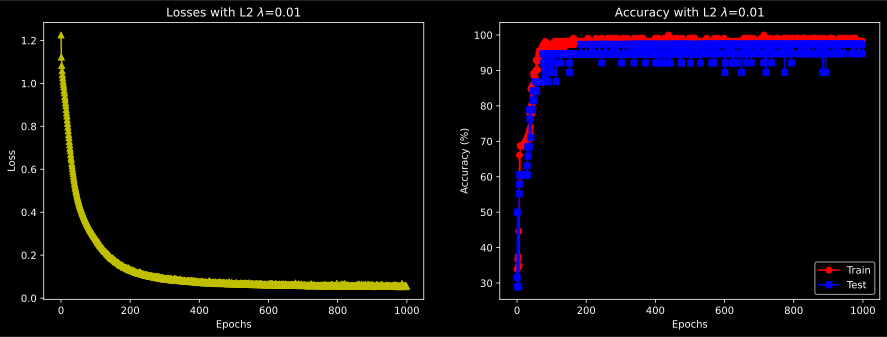

In [53]:
fig, axs = plt.subplots(1,2, figsize=(15,5))

axs[0].plot(losses,'y^-')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_title('Losses with L2 $\lambda$=' + str(l2_lambda))

axs[1].plot(train_accs,'ro-')
axs[1].plot(test_accs,'bs-')
axs[1].set_title('Accuracy with L2 $\lambda$=' + str(l2_lambda))
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend(['Train','Test']);

In [54]:
#realizamos el filtro de suavizado para nuestras gráficas
def smooth(x, k):
    return np.convolve(x, np.ones(k)/k, mode="same")

## Hora del Experimento!

In [56]:
l2_lambdas = np.linspace(0, 0.1, 10) #vector de 10 números linealmente espaciados de 0 a 0.1
#será nuestro parámetro de penalización del error (L2)

In [59]:
from tqdm import tqdm

In [61]:
exp_train_accs = np.zeros((n_epochs, len(l2_lambdas)))
exp_test_accs = np.zeros((n_epochs, len(l2_lambdas)))

for lambda_idx in tqdm(range(len(l2_lambdas))):
    
    model, loss_func, optim = create_model(l2_lambdas[lambda_idx])
    train_accs, test_accs, losses = train_model(model, loss_func, optim)
    
    #almacenando los resultados
    
    # exp_train_accs[:,lambda_idx] = smooth(train_accs, 10)
    # exp_test_accs[:,lambda_idx] = smooth(test_accs, 10)
    exp_train_accs[:,lambda_idx] = train_accs 
    exp_test_accs[:,lambda_idx] = test_accs

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:02<00:00,  6.23s/it]


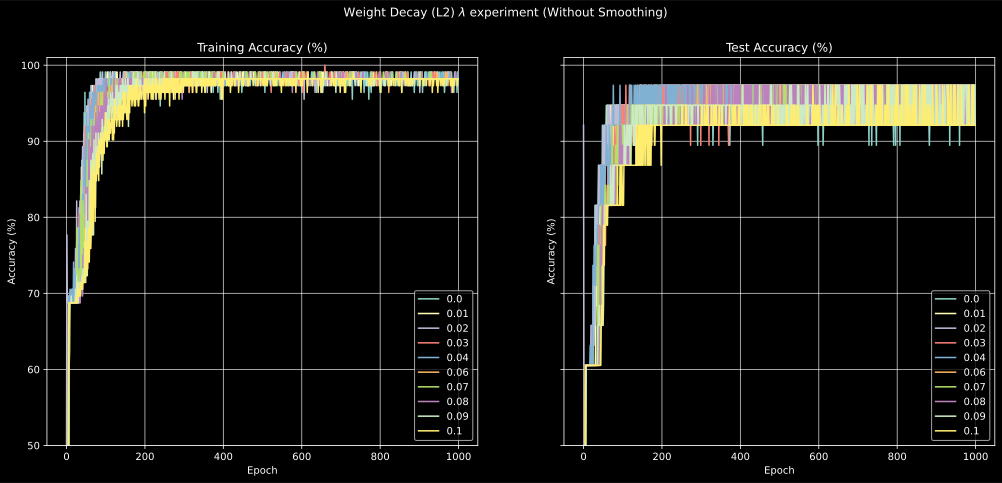

In [89]:
fig, axs = plt.subplots(1,2, figsize=(17,7), sharey=True)

fig.suptitle("Weight Decay (L2) $\lambda$ experiment (Without Smoothing)")
axs[0].plot(exp_train_accs)
axs[0].set_title("Training Accuracy (%)")
axs[1].plot(exp_test_accs)
axs[1].set_title("Test Accuracy (%)")

for i in range(2):
    axs[i].legend(np.round(l2_lambdas, 2));
    axs[i].set_xlabel("Epoch")
    axs[i].set_ylabel("Accuracy (%)")
    axs[i].set_ylim([50, 101])
    axs[i].grid(alpha=0.8);
    
plt.plot();

In [90]:
smooth_exp_train_accs = np.zeros_like(exp_train_accs)
smooth_exp_test_accs = np.zeros_like(exp_test_accs)

for i in range(len(l2_lambdas)):
    
    smooth_exp_train_accs[:,i] = smooth(exp_train_accs[:,i],2)
    smooth_exp_test_accs[:,i] = smooth(exp_test_accs[:,i],2)
    

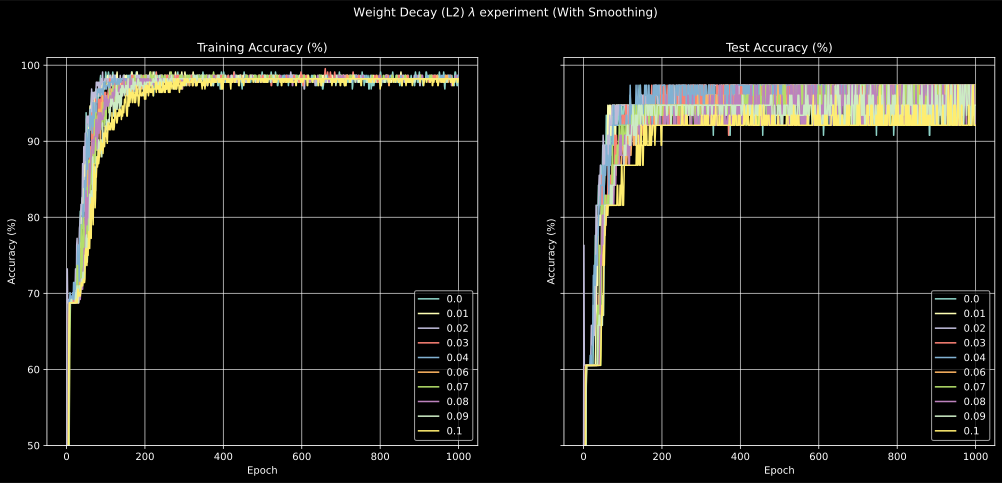

In [91]:
fig, axs = plt.subplots(1,2, figsize=(17,7), sharey=True)

fig.suptitle("Weight Decay (L2) $\lambda$ experiment (With Smoothing)")
axs[0].plot(smooth_exp_train_accs)
axs[0].set_title("Training Accuracy (%)")
axs[1].plot(smooth_exp_test_accs)
axs[1].set_title("Test Accuracy (%)")

for i in range(2):
    axs[i].legend(np.round(l2_lambdas, 2));
    axs[i].set_xlabel("Epoch")
    axs[i].set_ylabel("Accuracy (%)")
    axs[i].set_ylim([50, 101])
    axs[i].grid(alpha=0.8);
    
plt.plot();

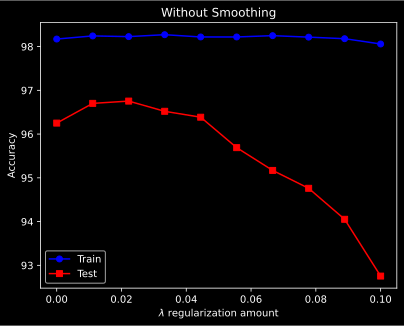

In [95]:
#ahora, visualizaremos tan solo la evolución del entrenamiento del modelo en las epoch 500-950
#tomaremos la media de las precisones

epoch_range = [500,950]


plt.plot(l2_lambdas,
         np.mean(exp_train_accs[epoch_range[0]:epoch_range[1],:],axis=0),
         'bo-',label='Train')

plt.plot(l2_lambdas,
         np.mean(exp_test_accs[epoch_range[0]:epoch_range[1],:],axis=0),
         'rs-',label='Test')

plt.title("Without Smoothing")
plt.xlabel('$\lambda$ regularization amount')
plt.ylabel('Accuracy')
plt.legend()
plt.show();

Podemos ver, que parece ser que ligeramente mejora el rendimiento en testing del modelo con un valor de $\large{\lambda}$ de alrededor del `0.02`, pero la tendencia clara en este caso es que valores mayores a dicho valor, harán el modelo funcionar peor.

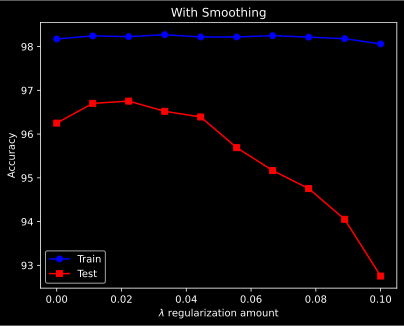

In [96]:
epoch_range = [500,950]


plt.plot(l2_lambdas,
         np.mean(smooth_exp_train_accs[epoch_range[0]:epoch_range[1],:],axis=0),
         'bo-',label='Train')

plt.plot(l2_lambdas,
         np.mean(smooth_exp_test_accs[epoch_range[0]:epoch_range[1],:],axis=0),
         'rs-',label='Test')

plt.title("With Smoothing")
plt.xlabel('$\lambda$ regularization amount')
plt.ylabel('Accuracy')
plt.legend()
plt.show();